# Diffraction Spectrum of a Finite Binary Grating

Finally, we can validate the results for the diffraction spectra of a finite grating via a different approach than computing the far fields: as the (spatial) Fourier transform of the scattered fields. This involves two simulations &mdash; one with the grating and the other with just a flat surface &mdash; and subtracting the Fourier-transformed fields at a given frequency ω from the two runs to obtain the scattered fields s(y). The Fourier transform of the scattered fields is then computed in post processing: a(k<sub>y</sub>) = ∫ s(y) exp(ik<sub>y</sub>y) dy, where |a(k<sub>y</sub>)|² is the amplitude of the corresponding Fourier component. For a grating with periodicity Λ, we should expect to see peaks in the diffraction spectra at k<sub>y</sub>=2πm/Λ for m=0, ±1, ±2, ... The total number of diffraction orders is determined by the wavelength as described in [Tutorials/Mode Decomposition/Transmittance Spectra for Planewave at Normal Incidence](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#transmittance-spectra-for-planewave-at-normal-incidence).

The simulation setup is shown in the schematic below. The binary grating has Λ = 1 μm at a wavelength of 0.5 μm via a normally-incident planewave pulse (which must [extend into the PML region in order to span the entire width of the cell](https://meep.readthedocs.io/en/latest/Perfectly_Matched_Layer/#planewave-sources-extending-into-pml)). The grating structure is terminated with a flat-surface padding in order to give the scattered field space to decay at the edge of the cell.

![](https://meep.readthedocs.io/en/latest/images/finite_grating_schematic.png)

In [1]:
import meep as mp
import numpy as np
import math
import matplotlib.pyplot as plt

# True:  plot the scattered fields in the extended air region adjacent to the grating
# False: plot the diffraction spectra based on a 1d cross section of the scattered fields
field_profile = True

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 2.0  # substrate thickness
dpad = 1.0  # flat-surface padding
gp = 1.0  # grating periodicity
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle
num_cells = 5  # number of grating unit cells

# air region thickness adjacent to grating
dair = 10 if field_profile else dpad

wvl = 0.5  # center wavelength
fcen = 1 / wvl  # center frequency

k_point = mp.Vector3()

glass = mp.Medium(index=1.5)

pml_layers = [mp.PML(thickness=dpml)]

symmetries = [mp.Mirror(mp.Y)]

sx = dpml + dsub + gh + dair + dpml
sy = dpml + dpad + num_cells * gp + dpad + dpml
cell_size = mp.Vector3(sx, sy)

src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=0.2 * fcen),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy),
    )
]

geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    )
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dair)
near_fields = sim.add_dft_fields(
    [mp.Ez],
    fcen,
    0,
    1,
    center=mon_pt,
    size=mp.Vector3(dair if field_profile else 0, sy - 2 * dpml),
)

sim.run(until_after_sources=100)

flat_dft = sim.get_dft_array(near_fields, mp.Ez, 0)

sim.reset_meep()

for j in range(num_cells):
    geometry.append(
        mp.Block(
            material=glass,
            size=mp.Vector3(gh, gdc * gp, mp.inf),
            center=mp.Vector3(
                -0.5 * sx + dpml + dsub + 0.5 * gh,
                -0.5 * sy + dpml + dpad + (j + 0.5) * gp,
            ),
        )
    )

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

near_fields = sim.add_dft_fields(
    [mp.Ez],
    fcen,
    0,
    1,
    center=mon_pt,
    size=mp.Vector3(dair if field_profile else 0, sy - 2 * dpml),
)

sim.run(until_after_sources=100)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00181007 s
Working in 2D dimensions.
Computational cell is 14.5 x 9 x 0 with resolution 50
     block, center = (-5.75,0,0)
          size (3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.610417 s
-----------
Meep progress: 9.18/125.0 = 7.3% done in 4.0s, 50.5s to go
on time step 918 (time=9.18), 0.00435765 s/step
Meep progress: 18.490000000000002/125.0 = 14.8% done in 8.0s, 46.1s to go
on time step 1849 (time=18.49), 0.00429697 s/step
Meep progress: 27.810000000000002/125.0 = 22.2% done in 12.0s, 42.0s to go
on time step 2781 (time=27.81), 0.00429364 s/step
Meep progress: 37.160000000000004/125.0 = 29.7% done in 16.0s, 37.8s to go
on time step 3716 (time=37.16), 0.0042805 s/step
Meep progress: 46.44/125.0 = 37.2% done in 20.0s, 33.9s to go
on time step 4644 (time=46.44), 0

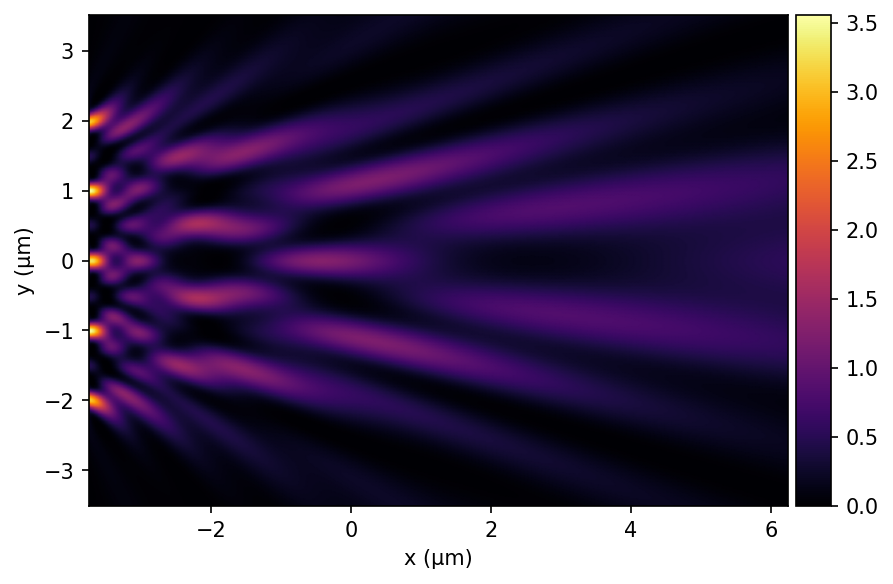

In [2]:
grating_dft = sim.get_dft_array(near_fields, mp.Ez, 0)

scattered_field = grating_dft - flat_dft
scattered_amplitude = np.abs(scattered_field) ** 2

[x, y, z, w] = sim.get_array_metadata(dft_cell=near_fields)

if field_profile:
    plt.figure(dpi=150)
    plt.pcolormesh(
        x,
        y,
        np.rot90(scattered_amplitude),
        cmap="inferno",
        shading="gouraud",
        vmin=0,
        vmax=scattered_amplitude.max(),
    )
    plt.gca().set_aspect("equal")
    plt.xlabel("x (μm)")
    plt.ylabel("y (μm)")
    # ensure that the height of the colobar matches that of the plot
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.tight_layout()
    plt.show()
else:
    ky = np.fft.fftshift(np.fft.fftfreq(len(scattered_field), 1 / resolution))
    FT_scattered_field = np.fft.fftshift(np.fft.fft(scattered_field))
    plt.figure(dpi=150)
    plt.subplots_adjust(hspace=0.3)

    plt.subplot(2, 1, 1)
    plt.plot(y, scattered_amplitude, "bo-")
    plt.xlabel("y (μm)")
    plt.ylabel("field amplitude")

    plt.subplot(2, 1, 2)
    plt.plot(ky, np.abs(FT_scattered_field) ** 2, "ro-")
    plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    plt.xlabel(r"wavevector k$_y$, 2π (μm)$^{-1}$")
    plt.ylabel("Fourier transform")
    plt.gca().set_xlim([-3, 3])

    plt.tight_layout(pad=1.0)
    plt.show()

Results are shown for two finite gratings with 5 and 20 periods.

![](https://meep.readthedocs.io/en/latest/images/finite_grating_nperiods5.png)

![](https://meep.readthedocs.io/en/latest/images/finite_grating_nperiods20.png)

The scattered field amplitude profile (the top figure in each of the two sets of results) shows that the fields are nonzero above the grating (which is positioned at the left edge of the figure in the region indicated by the bright spots) and decay to zero away from the grating. The middle figure is the field amplitude along a 1d slice at a distance 1.5 μm above the grating (marked by the dotted green line in the top figure). Note the decaying fields at the edges due to the flat-surface termination. The bottom figure is the Fourier transform of the fields from the 1d slice. As expected, there are only three diffraction orders present at k<sub>y</sub>=2πm/Λ for m=0, ±1, ±2. These peaks are becoming sharper as the number of grating periods increases.

The sharpness of the peaks directly corresponds to how [collimated](https://en.wikipedia.org/wiki/Collimated_beam) the diffracted beams are, and in the limit of infinitely many periods the resulting delta-function peaks correspond to diffracted planewaves. (The squared amplitude of each peak is proportional to the power in the corresponding diffraction order.) One can also obtain the collimation of the beams more directly by using Meep's `near2far` feature to compute the far-field diffracted waves — this approach is more straightforward, but potentially much more expensive than looking at the Fourier transform of the near field, because one may need a large number of far-field points to resolve the full diffracted beams. In general, [there is a tradeoff in computational science](https://icerm.brown.edu/video_archive/?play=1626) between doing direct "numerical experiments" that are conceptually straightforward but often expensive, versus more indirect and tricky calculations that don't directly correspond to laboratory experiments but which can sometimes be vastly more efficient at extracting physical information.

In 3d, the procedure is very similar, but a little more effort is required to disentangle the two polarizations relative to the plane of incidence [the (z,**k**) plane for each Fourier component **k**]. For propagation in the $z$ direction, you would Fourier transform both $E_x$ and $E_y$ of the scattered field as a function of **k** $= (k_x, k_y)$.  For each **k**, you decompose the corresponding **E** $= (E_x, E_y)$ into the amplitude parallel to **k** [which gives the *p* polarization amplitude if you multiply by csc(θ), where cos(θ)=|**k**|/(nω/c), n is the refractive index of the ambient medium, and ω is the angular frequency] and perpendicular to **k** [which equals the *s* polarization amplitude].  Then square these amplitudes to get something proportional to power as above.  (Note that this analysis is the same even if the incident wave is at an oblique angle, although the **k** locations of the diffraction peaks will change.)